## Alzheimer

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn import svm
from sklearn.metrics import auc, roc_auc_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import pickle



## Data reading and preliminary analysis

In [4]:
### Origin: https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset
alz = pd.read_csv('../data/class/raw/alzheimers_disease_data.csv',index_col='PatientID')
alz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2149 entries, 4751 to 6899
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64  

In [4]:
alz.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
PatientID,,,,,,,,,,,,,,,,,,,,,
4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,9.025679,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,7.151293,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,9.673574,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,8.392554,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,5.597238,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


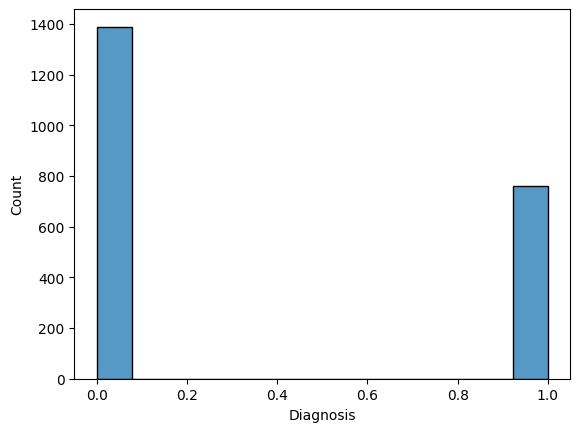

In [5]:
sns.histplot(alz['Diagnosis']);

<Axes: >

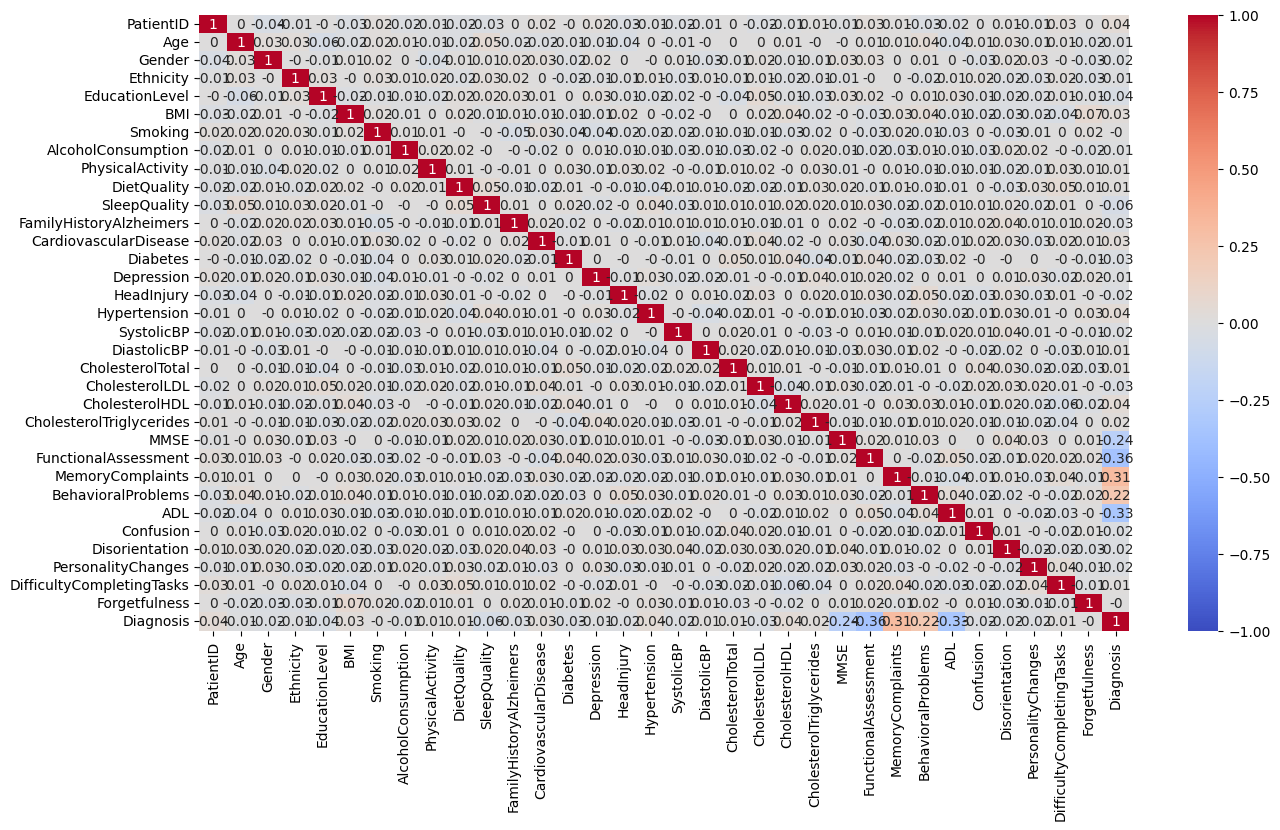

In [ ]:
alz_num = alz.select_dtypes(include=['int','float'])
plt.figure(figsize=(15,8))
sns.heatmap(round(alz_num.corr(),2), vmin=-1,annot=True,cmap='coolwarm')


In [6]:
### Datasets divided by category
alz_dem = alz[['Age','Gender','Ethnicity','EducationLevel','Diagnosis']]
alz_lif = alz[['BMI','Smoking','AlcoholConsumption','PhysicalActivity','DietQuality','SleepQuality','Diagnosis']]
alz_med = alz[['FamilyHistoryAlzheimers','CardiovascularDisease','Diabetes','Depression','HeadInjury','Hypertension','Diagnosis']]
alz_cli = alz[['SystolicBP','DiastolicBP','CholesterolTotal','CholesterolLDL','CholesterolHDL','CholesterolTriglycerides','Diagnosis']]
alz_cog = alz[['MMSE','FunctionalAssessment','MemoryComplaints','BehavioralProblems','ADL','Diagnosis']]
alz_sym = alz[['Confusion','Disorientation','PersonalityChanges','DifficultyCompletingTasks','Forgetfulness','Diagnosis']]

In [ ]:
### Aggregated values
alz['medical_conditions']= -alz['FamilyHistoryAlzheimers'] + alz['CardiovascularDisease']-alz['Diabetes']-alz['Depression']-alz['HeadInjury']+alz['Hypertension']
alz['demographics']= 

<Axes: >

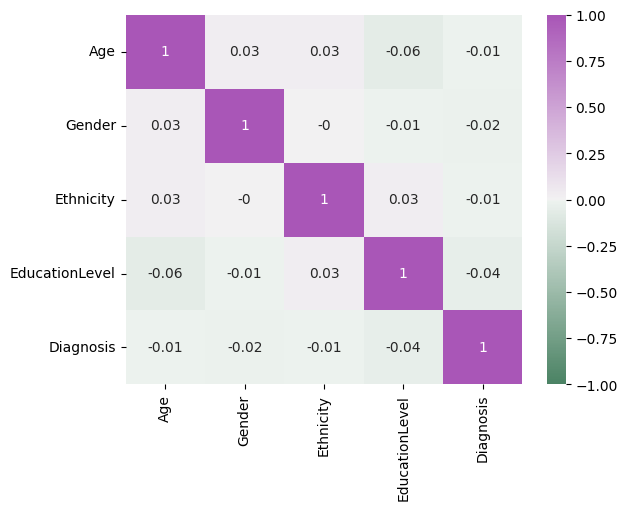

In [18]:
palette = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(round(alz_dem.corr(),2), vmin=-1,annot=True, cmap=palette)


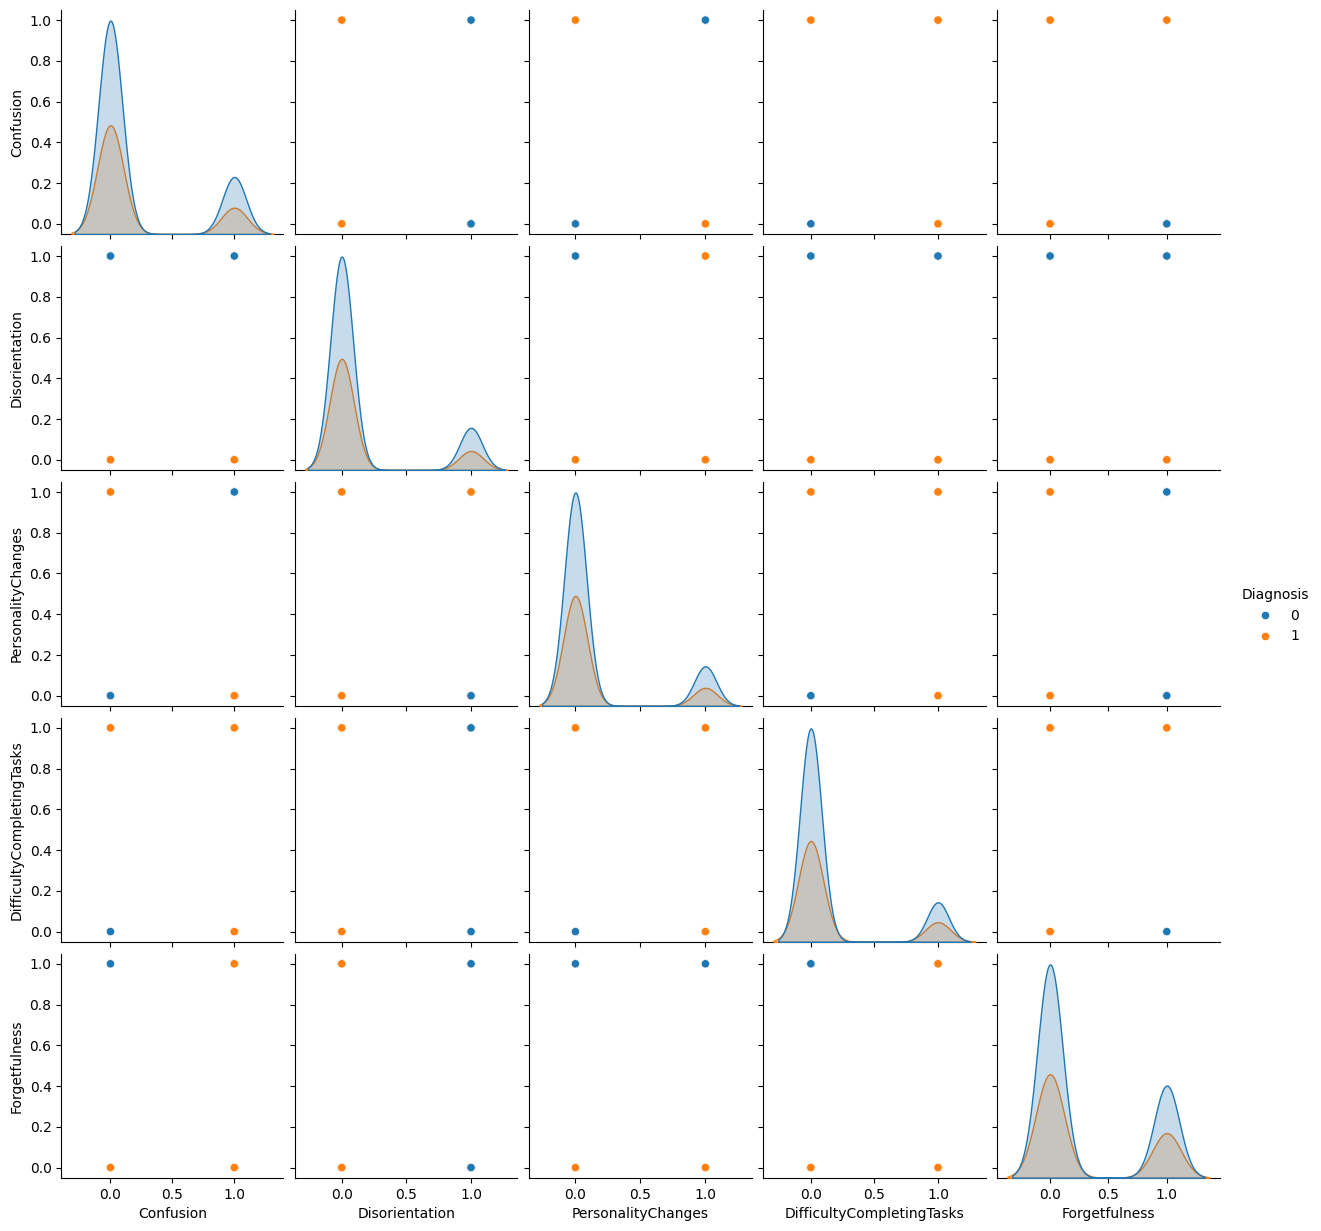

In [15]:
sns.pairplot(data=alz_sym,hue='Diagnosis')

Further investigation shows no further option of a better model inducing feature engeneering

## Model #2

This second model has three priorities over the baseline model:
- A broader selection of input variables, which will be reduced further with PCA.
- A priorization on recall over other measures (we want to make sure we get all the positives, even if we get more false positives in the way).
- A hyperparametrization, to get the best possible result

### Variable selection and PCA

Variables with over 0.05 correlation with the target are selected. If any combination of variables reach that number, it is also included.

In [ ]:
alz_2 = alz[['medical_conditions',]]